In [ ]:
import sys
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [1]:
import sys
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import keras

Instructions for updating:
non-resource variables are not supported in the long term


In [70]:
mnist = tf.keras.datasets.mnist

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
train_data, test_data = train_data / 255.0, test_data / 255.0

# Add a channels dimension
train_data = train_data[..., tf.newaxis].astype("float32")
test_data = test_data[..., tf.newaxis].astype("float32")


VALIDATION_SIZE = 5000
validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]
params = [32, 32, 64, 64, 200, 200]
batch_size = 128

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))
val_dataset = val_dataset.batch(batch_size)

class MNIST:
    def __init__(self, train_data, train_labels, validation_data, validation_labels, test_data, test_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.validation_data = validation_data
        self.validation_labels = validation_labels

mnist_data = MNIST(train_data, train_labels, validation_data, validation_labels, test_data, test_labels)


def show(img):
    """
    Show MNSIT digits in the console.
    """
    remap = "  .*#"+"#"*100
    img = (img.flatten()+.5)*3
    if len(img) != 784: return
    print("START")
    for i in range(28):
        print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))

def get_model(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    # model.add(Activation('softmax'))

    return model

In [ ]:
basic_model = get_model(mnist_data, "mnistModel", params)

import keras
# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
# Instantiate a loss function.
loss_fn1 = tf.nn.softmax_cross_entropy_with_logits
loss_fn2 = keras.losses.BinaryCrossentropy()
loss_fn3 = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()


@tf.function
def train_step(x1, y, yprob):
    with tf.GradientTape() as tape:
        logits1 = basic_model(x1, training=True)
        loss_value = tf.reduce_mean(loss_fn1(yprob, logits1))
    grads = tape.gradient(loss_value, basic_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, basic_model.trainable_weights))
    train_acc_metric.update_state(y, logits1)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = basic_model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

(55000, 28, 28, 1)


In [ ]:
print(basic_model.summary())

In [ ]:
# Training model
import time
import math 
std = 0.01
epochs = 5

total_steps = sum(1 for _ in train_dataset)

for epoch in range(epochs):
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Compute loss
        loss_value = train_step(x_batch_train, y_batch_train, tf.one_hot(y_batch_train, 10))
        print('\r', "Epoch %d" % (epoch,), 'Training step:', step+1, f'/{total_steps}', 'Loss:', float(loss_value), 'Acc:', float(train_acc_metric.result()), end='')
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("\nTraining acc over epoch: %.4f" % (float(train_acc),), end=' ')

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),), end=' ')
    print("Time taken: %.2fs\n" % (time.time() - start_time))

 Epoch 0 Training step: 430 /430 Loss: 0.14182710647583008 Acc: 0.8337273001670837
Training acc over epoch: 0.8337 Validation acc: 0.9726 Time taken: 37.46s

 Epoch 1 Training step: 430 /430 Loss: 0.1076287105679512 Acc: 0.96143639087677
Training acc over epoch: 0.9614 Validation acc: 0.9810 Time taken: 4.39s

 Epoch 2 Training step: 430 /430 Loss: 0.07328467071056366 Acc: 0.9723636507987976
Training acc over epoch: 0.9724 Validation acc: 0.9856 Time taken: 4.34s

 Epoch 3 Training step: 430 /430 Loss: 0.013835951685905457 Acc: 0.977581799030304
Training acc over epoch: 0.9776 Validation acc: 0.9860 Time taken: 4.41s

 Epoch 4 Training step: 430 /430 Loss: 0.03370736539363861 Acc: 0.9815090894699097
Training acc over epoch: 0.9815 Validation acc: 0.9876 Time taken: 4.41s



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
basic_model = tf.keras.models.load_model('/content/drive/MyDrive/CS726/basic_model')
pgd_model = tf.keras.models.load_model('/content/drive/MyDrive/CS726/pgd_model')
stab_model = tf.keras.models.load_model('/content/drive/MyDrive/CS726/stab_model')

In [8]:
import math

In [ ]:
CONFIDENCE = 0
LEARNING_RATE = 1e-2
CONST = 1
boxmin = -0.5 
boxmax = 0.5
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

batch_size = 128
k = math.ceil(test_data.shape[0] // batch_size)
cw_adv_basic = []
for i in range(k):
  imgs = test_data[i*batch_size:min((i+1)*batch_size,test_data.shape[0]), :,:,:]
  yprob = tf.one_hot(test_labels[i*batch_size:min((i+1)*batch_size,test_data.shape[0])], 10)
  print(i*batch_size, min((i+1)*batch_size,test_data.shape[0]))
  print(yprob.shape, imgs.shape)
  # print(np.arctanh((imgs - boxplus) / boxmul * 0.999999))
  timg = tf.convert_to_tensor(np.arctanh((imgs - 0.5) / 0.5 * 0.999999))
  modifier = np.zeros(imgs.shape,dtype=np.float32)
  modifier_tensor = tf.Variable(modifier)

  optimizer = keras.optimizers.Adam(LEARNING_RATE)
  for i in range(1000):
      with tf.GradientTape() as t:
          t.watch(modifier_tensor)
          newimg = tf.tanh(modifier_tensor + timg) * boxmul + 0.5
          # newimg = tf.tanh(modifier_tensor + 1) * boxmul
          logits1 = basic_model(newimg, training=True)
          l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * 0.5 + 0.5)),[1,2,3])
          loss2 = tf.reduce_sum(l2dist) # sum l2 distance
          # loss1 = loss_fn3(y, logits1)
          real = tf.reduce_sum((yprob)*logits1,1)
          other = tf.reduce_max((1-yprob)*logits1 - (yprob*10000),1)
          loss1 = CONST * tf.reduce_sum(tf.maximum(0.0, real-other+CONFIDENCE))
          loss_value = loss1 + loss2
      # result = loss_value
      grads = t.gradient(loss_value, modifier_tensor)

      optimizer.apply_gradients(zip([grads], [modifier_tensor]))
      print('\r', "i %d" % (i,), 'Loss 1:', float(loss1), 'Loss 2:', float(loss2), 'Loss:', float(loss_value), end='')
  cw_adv_basic.append((tf.tanh(modifier_tensor + timg) * boxmul + 0.5).numpy())

cw_adv_basic =  np.concatenate(cw_adv_basic, axis=0)

In [29]:
CONFIDENCE = 0
LEARNING_RATE = 1e-2
CONST = 500
boxmin = -0.5 
boxmax = 0.5
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

batch_size = 128
imgs = test_data[:batch_size, :,:,:]
yprob = tf.one_hot(test_labels[:batch_size], 10)
print(yprob.shape, imgs.shape)
# print(np.arctanh((imgs - boxplus) / boxmul * 0.999999))
timg = tf.convert_to_tensor(np.arctanh((imgs - 0.5) / 0.5 * 0.999999))
modifier = np.zeros((batch_size, 28, 28, 1),dtype=np.float32)
modifier_tensor = tf.Variable(modifier)

optimizer = keras.optimizers.Adam(LEARNING_RATE)
for i in range(1000):
    with tf.GradientTape() as t:
        t.watch(modifier_tensor)
        newimg = tf.tanh(modifier_tensor + timg) * boxmul + 0.5
        # newimg = tf.tanh(modifier_tensor + 1) * boxmul
        logits1 = basic_model(newimg, training=True)
        l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * 0.5 + 0.5)),[1,2,3])
        loss2 = tf.reduce_sum(l2dist) # sum l2 distance
        # loss1 = loss_fn3(y, logits1)
        real = tf.reduce_sum((yprob)*logits1,1)
        other = tf.reduce_max((1-yprob)*logits1 - (yprob*10000),1)
        loss1 = CONST * tf.reduce_sum(tf.maximum(0.0, real-other+CONFIDENCE))
        loss_value = loss1 + loss2
    # result = loss_value
    grads = t.gradient(loss_value, modifier_tensor)

    optimizer.apply_gradients(zip([grads], [modifier_tensor]))
    print('\r', "i %d" % (i,), 'Loss 1:', float(loss1), 'Loss 2:', float(loss2), 'Loss:', float(loss_value), end='')
cw_adv_basic = (tf.tanh(modifier_tensor + timg) * boxmul + 0.5).numpy()

(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 10999.4326171875 Loss 2: 1154.385009765625 Loss: 12153.8173828125

In [40]:
CONFIDENCE = 0
LEARNING_RATE = 1e-2
CONST = 500
boxmin = -0.5 
boxmax = 0.5
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

batch_size = 128
imgs = train_data[:batch_size, :,:,:]
yprob = tf.one_hot(train_labels[:batch_size], 10)
print(yprob.shape, imgs.shape)
# print(np.arctanh((imgs - boxplus) / boxmul * 0.999999))
timg = tf.convert_to_tensor(np.arctanh((imgs - 0.5) / 0.5 * 0.999999))
modifier = np.zeros((batch_size, 28, 28, 1),dtype=np.float32)
modifier_tensor = tf.Variable(modifier)

optimizer = keras.optimizers.Adam(LEARNING_RATE)
for i in range(1000):
    with tf.GradientTape() as t:
        t.watch(modifier_tensor)
        newimg = tf.tanh(modifier_tensor + timg) * boxmul + 0.5
        # newimg = tf.tanh(modifier_tensor + 1) * boxmul
        logits1 = pgd_model(newimg, training=True)
        l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * 0.5 + 0.5)),[1,2,3])
        loss2 = tf.reduce_sum(l2dist) # sum l2 distance
        # loss1 = loss_fn3(y, logits1)
        real = tf.reduce_sum((yprob)*logits1,1)
        other = tf.reduce_max((1-yprob)*logits1 - (yprob*10000),1)
        loss1 = CONST * tf.reduce_sum(tf.maximum(0.0, real-other+CONFIDENCE))
        loss_value = loss1 + loss2
    # result = loss_value
    grads = t.gradient(loss_value, modifier_tensor)

    optimizer.apply_gradients(zip([grads], [modifier_tensor]))
    print('\r', "i %d" % (i,), 'Loss 1:', float(loss1), 'Loss 2:', float(loss2), 'Loss:', float(loss_value), end='')
cw_adv_pgd = (tf.tanh(modifier_tensor + timg) * boxmul + 0.5).numpy()

(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 19248.87890625 Loss 2: 1048.982177734375 Loss: 20297.861328125

In [34]:
CONFIDENCE = 0
LEARNING_RATE = 1e-2
CONST = 500
boxmin = -0.5 
boxmax = 0.5
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

batch_size = 128
imgs = test_data[:batch_size, :,:,:]
yprob = tf.one_hot(test_labels[:batch_size], 10)
print(yprob.shape, imgs.shape)
# print(np.arctanh((imgs - boxplus) / boxmul * 0.999999))
timg = tf.convert_to_tensor(np.arctanh((imgs - 0.5) / 0.5 * 0.999999))
modifier = np.zeros((batch_size, 28, 28, 1),dtype=np.float32)
modifier_tensor = tf.Variable(modifier)

optimizer = keras.optimizers.Adam(LEARNING_RATE)
for i in range(1000):
    with tf.GradientTape() as t:
        t.watch(modifier_tensor)
        newimg = tf.tanh(modifier_tensor + timg) * boxmul + 0.5
        # newimg = tf.tanh(modifier_tensor + 1) * boxmul
        logits1 = stab_model(newimg, training=True)
        l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * 0.5 + 0.5)),[1,2,3])
        loss2 = tf.reduce_sum(l2dist) # sum l2 distance
        # loss1 = loss_fn3(y, logits1)
        real = tf.reduce_sum((yprob)*logits1,1)
        other = tf.reduce_max((1-yprob)*logits1 - (yprob*10000),1)
        loss1 = CONST * tf.reduce_sum(tf.maximum(0.0, real-other+CONFIDENCE))
        loss_value = loss1 + loss2
    # result = loss_value
    grads = t.gradient(loss_value, modifier_tensor)

    optimizer.apply_gradients(zip([grads], [modifier_tensor]))
    print('\r', "i %d" % (i,), 'Loss 1:', float(loss1), 'Loss 2:', float(loss2), 'Loss:', float(loss_value), end='')
cw_adv_stab = (tf.tanh(modifier_tensor + timg) * boxmul + 0.5).numpy()

(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 10022.5361328125 Loss 2: 1400.6063232421875 Loss: 11423.142578125

In [71]:
CONFIDENCE = 0
LEARNING_RATE = 1e-2
boxmin = -0.5 
boxmax = 0.5
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

cw_adv_stab = np.copy(test_data[:batch_size,:,:,:])

for CONST_FACTOR in range(5):
  CONST = 1 + CONST_FACTOR * 100
  print(CONST)
  batch_size = 128
  imgs = test_data[:batch_size, :,:,:]
  yprob = tf.one_hot(test_labels[:batch_size], 10)
  print(yprob.shape, imgs.shape)
  # print(np.arctanh((imgs - boxplus) / boxmul * 0.999999))
  timg = tf.convert_to_tensor(np.arctanh((imgs - 0.5) / 0.5 * 0.999999))
  modifier = np.zeros((batch_size, 28, 28, 1),dtype=np.float32)
  modifier_tensor = tf.Variable(modifier)

  optimizer = keras.optimizers.Adam(LEARNING_RATE)
  for i in range(1000):
      with tf.GradientTape() as t:
          t.watch(modifier_tensor)
          newimg = tf.tanh(modifier_tensor + timg) * boxmul + 0.5
          # newimg = tf.tanh(modifier_tensor + 1) * boxmul
          logits1 = stab_model(newimg, training=True)
          l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * 0.5 + 0.5)),[1,2,3])
          loss2 = tf.reduce_sum(l2dist) # sum l2 distance
          # loss1 = loss_fn3(y, logits1)
          real = tf.reduce_sum((yprob)*logits1,1)
          other = tf.reduce_max((1-yprob)*logits1 - (yprob*10000),1)
          loss1 = CONST * tf.reduce_sum(tf.maximum(0.0, real-other+CONFIDENCE))
          loss_value = loss1 + loss2
      # result = loss_value
      grads = t.gradient(loss_value, modifier_tensor)

      optimizer.apply_gradients(zip([grads], [modifier_tensor]))
      print('\r', "i %d" % (i,), 'Loss 1:', float(loss1), 'Loss 2:', float(loss2), 'Loss:', float(loss_value), end='')
  cw_adv_stab_temp = (tf.tanh(modifier_tensor + timg) * boxmul + 0.5).numpy()
  for i in range(batch_size):
    if np.argmax(stab_model(cw_adv_stab[i,:,:,:][np.newaxis,:,:,:])) == test_labels[i] or (np.argmax(stab_model(cw_adv_stab_temp[i,:,:,:][np.newaxis,:,:,:])) != test_labels[i] and np.sum((cw_adv_stab_temp[i,:,:,:]-test_data[i,:,:,:])**2) < np.sum((cw_adv_stab[i,:,:,:]-test_data[i,:,:,:])**2)):
      cw_adv_stab[i] = cw_adv_stab_temp[i]      
# cw_adv_stab = (tf.tanh(modifier_tensor + timg) * boxmul + 0.5).numpy()

1
(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 122.79732513427734 Loss 2: 1.5542774200439453 Loss: 124.35160064697266101
(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 5465.60791015625 Loss 2: 496.125732421875 Loss: 5961.7333984375201
(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 8092.18359375 Loss 2: 788.72900390625 Loss: 8880.912109375301
(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 8999.9931640625 Loss 2: 1075.9632568359375 Loss: 10075.9560546875401
(128, 10) (128, 28, 28, 1)
 i 999 Loss 1: 10139.525390625 Loss 2: 1252.7313232421875 Loss: 11392.2568359375

2
30.09211


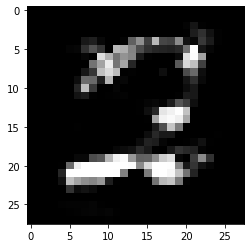

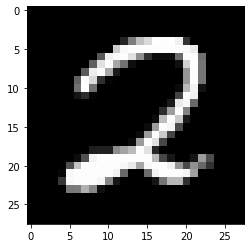

In [72]:
i = 35
x_l2 = cw_adv_stab[i,:,:,:]
# show(x_l2)

import matplotlib.pyplot as plt

im_l2 = x_l2.reshape(28, 28)
plt.gray()
plt.imshow(im_l2)
plt.figure()
plt.imshow(test_data[i,:,:,:].reshape(28,28))
print(test_labels[i])
print(np.sum((x_l2-test_data[i,:,:,:])**2))

In [73]:
l2dists = []
for i in range(128):
  x_l2 = cw_adv_stab[i,:,:,:]
  l2dist = np.sum((x_l2-test_data[i,:,:,:])**2)
  l2dists.append(l2dist)

In [74]:
l2dists = np.array(l2dists)
print(np.mean(l2dists), np.max(l2dists), np.median(l2dists), np.min(l2dists))
print(np.sum(l2dists < 2))
print(np.argmax(l2dists))

6.741137 30.09211 6.636635 0.00017929226
28
35


In [37]:
def test_attack_single_input(model, adv, x, true_label, num_trials=10, std=0.01):
    # original input
    y = model(x)
    pred_label = np.argmax(y)
    count = np.zeros(10)
    for i in range(num_trials):
        x_noisy = x + np.random.normal(scale=std, size=x.shape)
        y_noisy = model(x_noisy)
        noisy_label = np.argmax(y_noisy)
        count[noisy_label] += 1
    noisy_label = np.argmax(count)

    # adv. input
    y_adv = model(adv)
    adv_label = np.argmax(y_adv)
    count = np.zeros(10)
    for i in range(num_trials):
        adv_noisy = adv + np.random.normal(scale=std, size=adv.shape)
        y_noisy_adv = model(adv_noisy)
        noisy_label_adv = np.argmax(y_noisy_adv)
        count[noisy_label_adv] += 1
    adv_noisy_label = np.argmax(count)
    print('\r', 'true:', true_label, 'pred:', pred_label, 'noisy_pred:', noisy_label, 'adv_pred:', adv_label, 'adv_noisy_pred:', adv_noisy_label, end='')

    return true_label, pred_label, noisy_label, adv_label, adv_noisy_label

def test_attack_multiple_inputs(model, cw_adv, num_runs=100):
    corr = 0
    noisy_corr = 0
    adv_corr = 0
    adv_noisy_corr = 0
    for run in range(num_runs):
        i = np.random.randint(0, 128)
        x = test_data[i,:,:,:][np.newaxis,:,:,:]
        adv = cw_adv[i,:,:,:][np.newaxis,:,:,:]
        true, pred, noisy_pred, adv_pred, adv_noisy_pred = test_attack_single_input(model, adv, x, test_labels[i], num_trials=10, std=.8)
        corr += (pred == true)
        noisy_corr += (true == noisy_pred)
        adv_corr += (true == adv_pred)
        adv_noisy_corr += (true == adv_noisy_pred)
    print(f'\nAcc Original: {corr/num_runs}, Acc Adv: {adv_corr/num_runs}, Acc Adv Noisy: {adv_noisy_corr/num_runs}, Acc Ori Noisy: {noisy_corr/num_runs}')


In [33]:
test_attack_multiple_inputs(basic_model, cw_adv_basic)

 true: 7 pred: 7 noisy_pred: 7 adv_pred: 8 adv_noisy_pred: 8
Acc Original: 1.0, Acc Adv: 0.17, Acc Adv Noisy: 0.21, Acc Ori Noisy: 0.99


In [41]:
test_attack_multiple_inputs(pgd_model, cw_adv_pgd)

 true: 9 pred: 9 noisy_pred: 8 adv_pred: 2 adv_noisy_pred: 8
Acc Original: 1.0, Acc Adv: 0.1, Acc Adv Noisy: 0.02, Acc Ori Noisy: 0.09


In [38]:
test_attack_multiple_inputs(stab_model, cw_adv_stab)

 true: 9 pred: 9 noisy_pred: 9 adv_pred: 7 adv_noisy_pred: 9
Acc Original: 1.0, Acc Adv: 0.15, Acc Adv Noisy: 0.34, Acc Ori Noisy: 0.95


In [51]:
def test_robustness_single_input(model, adv, x, true_label, std=0.01, num_trials=100, alpha=2):
    y = model(x)
    pred_label = np.argmax(y)
    count = np.zeros(10)
    for i in range(num_trials):
        x_noisy = x + np.random.normal(scale=std, size=x.shape)
        y_noisy = model(x_noisy)
        noisy_label = np.argmax(y_noisy)
        count[noisy_label] += 1
    noisy_label = np.argmax(count)
    # total_counts = np.sum(count)
    # p1 = count[noisy_label] / total_counts
    # count[noisy_label] = -1
    # p2 = count[np.argmax(count)] / total_counts


    y_adv = model(adv)
    adv_label = np.argmax(y_adv)
    count = np.zeros(10)
    for i in range(num_trials):
        adv_noisy = adv + np.random.normal(scale=std, size=adv.shape)
        y_noisy_adv = model(adv_noisy)
        noisy_label_adv = np.argmax(y_noisy_adv)
        count[noisy_label_adv] += 1
    noisy_label_adv = np.argmax(count)
    total_counts = np.sum(count)
    p1 = count[noisy_label_adv] / total_counts
    count[noisy_label_adv] = -1
    p2 = count[np.argmax(count)] / total_counts

    alpha = 1.001
    while True:
        alpha *= 2
        if - 2*std**2 / alpha * np.log(1e-9+1-p1-p2+2*(1/2 * (p1**(1-alpha) + p2**(1-alpha))**(1/(1-alpha)) )) >= 0:
            L = np.sqrt(- 2*std**2 / alpha * np.log(1-p1-p2+2*(1/2 * (p1**(1-alpha) + p2**(1-alpha))**(1/(1-alpha)) ))) if p2 != 0 else 0.4
            break
    print('\r', pred_label, noisy_label, adv_label, noisy_label_adv, L, end='')
    return true_label, noisy_label, pred_label, adv_label, noisy_label_adv, count, L

def test_robustness_multiple_inputs(model, cw_adv, std=.5, num_trials=10, num_runs=100):
    score = 0
    L_avg = 0
    in_domain_score = 0
    count_in_domain = 0
    in_domain_similar = 0
    corr = 0
    noisy_corr = 0
    adv_corr = 0
    adv_noisy_corr = 0
    for run in range(num_runs):
        i = np.random.randint(0, 128)
        adv = cw_adv[i,:,:,:][np.newaxis,:,:,:]
        true, pred, noisy_pred, adv_pred, adv_noisy_pred, count, L = test_robustness_single_input(model, adv, test_data[i,:,:,:][np.newaxis,:,:,:], test_labels[i], num_trials=num_trials, std=std)
        corr += (pred == true)
        noisy_corr += (true == noisy_pred)
        adv_corr += (true == adv_pred)
        adv_noisy_corr += (true == adv_noisy_pred)

        if L >= np.sum((adv-test_data[i,:,:,:])**2):
            count_in_domain += 1
            in_domain_score += (true == adv_noisy_pred)
            in_domain_similar += (noisy_pred == adv_noisy_pred)
    # print(score)
    print(f'\nAcc Original: {corr/num_runs}, Acc Adv: {adv_corr/num_runs}, Acc Adv Noisy: {adv_noisy_corr/num_runs}, Acc Ori Noisy: {noisy_corr/num_runs}, In domain sim: {in_domain_similar / (count_in_domain+1e-9)}, In domain acc: {in_domain_score / (count_in_domain+1e-9)}, In domain counts: {count_in_domain}')
    # L_avg = L_avg / score if score != 0 else -1
    # return score / num_runs, L_avg

In [75]:
test_robustness_multiple_inputs(stab_model, cw_adv_stab)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


 1 1 1 1 0.4
Acc Original: 0.99, Acc Adv: 0.26, Acc Adv Noisy: 0.4, Acc Ori Noisy: 1.0, In domain sim: 0.9629629629272977, In domain acc: 0.9629629629272977, In domain counts: 27


In [58]:
test_robustness_multiple_inputs(basic_model, cw_adv_basic)

 7 7 3 3 0.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


 0 0 2 2 0.7753858255701761
Acc Original: 0.94, Acc Adv: 0.15, Acc Adv Noisy: 0.18, Acc Ori Noisy: 1.0, In domain sim: 0.9999999999285715, In domain acc: 0.9999999999285715, In domain counts: 14


In [59]:
test_robustness_multiple_inputs(pgd_model, cw_adv_pgd)

 9 4 1 8 0.5835901319604132

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


 4 4 9 8 0.5967304142118187
Acc Original: 0.67, Acc Adv: 0.17, Acc Adv Noisy: 0.03, Acc Ori Noisy: 1.0, In domain sim: 0.0, In domain acc: 0.0, In domain counts: 0
